**Author**: *Konstantinos Nikiforidis* (knikif@csd.auth.gr)  
**AEM**: *171*  
**Find and run the notebook online**: *https://colab.research.google.com/drive/1Kk_mDgh3uehwgsq1CS_bnfUZVt0u7hBI?usp=sharing*  
**GitHub**: *https://github.com/nikifori/Rock-Scissors-Paper-ML-CSD-2023*


# This is the FINAL submission of Final Project.
# The experiments done are included here: https://colab.research.google.com/drive/1vbuXxYwjP2udVs6WC02YB_H6iqKUU_C_?usp=sharing

# Final Project - Rock-Scissors-Paper Agent
Στόχος του project είναι η κατασκευή ενός ευφυούς πράκτορα που θα μάθει να παίζει το παιχνίδι Rock-
Scissor-paper. Ποιο συγκεκριμένα, ο πράκτορας θα βλέπει μία εικόνα που αντιστοιχεί σε 0: Πέτρα (Rock),

1: Ψαλίδι (Scissor) ή 2: Χαρτί (Paper) και θα επιλέγει το αντίστοιχο σύμβολο που το κερδίζει.  
  
Για την εκπαίδευση του πράκτορα σας, μπορείτε να χρησιμοποιήσετε το παρακάτω σύνολο δεδομένων:
https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors
το οποίο περιέχει 700+ εικόνες για κάθε κίνηση

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets
from transformers import ViTForImageClassification, ViTImageProcessor
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import pickle
import zipfile
import requests
from io import BytesIO
from pathlib import Path
from PIL import Image
import shutil
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from torch.utils.data import ConcatDataset
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Initiate the constants that are needed for the rest of the colab

In [ ]:
# CONSTANTS
RANDOM_STATE = 0
CLASS_LABELS = {'paper': 0, 'rock': 1, 'scissors': 2}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Download archive dataset from google drive share link and unzipped it locally in the virtual machine of Google Colab

In [ ]:
# specify share link
# url='https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1DbGUCCCwH_XuLwcCZ1--hGJ1dUzp90C9'
url='https://www.dropbox.com/scl/fi/1qyfz4whyqxpkvarnbk3e/rock_scissor_paper.zip?rlkey=cfko2e3rf5eb46v149dlsl6k5&dl=1'

def download_and_unzip(url, extract_to = '.'):
    print('Downloading...')
    response = requests.get(url)
    with zipfile.ZipFile(BytesIO(response.content)) as thezip:
        print('Unzipping...')
        thezip.extractall(path=extract_to)
    print('Downloading and Unzipping have finished...')
    print(os.listdir('.'))

# Invoke the function
download_and_unzip(url)

Downloading...
Unzipping...
['.config', 'scissors', 'paper', 'rock', 'rps-cv-images', 'README_rpc-cv-images.txt', 'sample_data']


# Print the number of images per folder and then print one instance from each folder

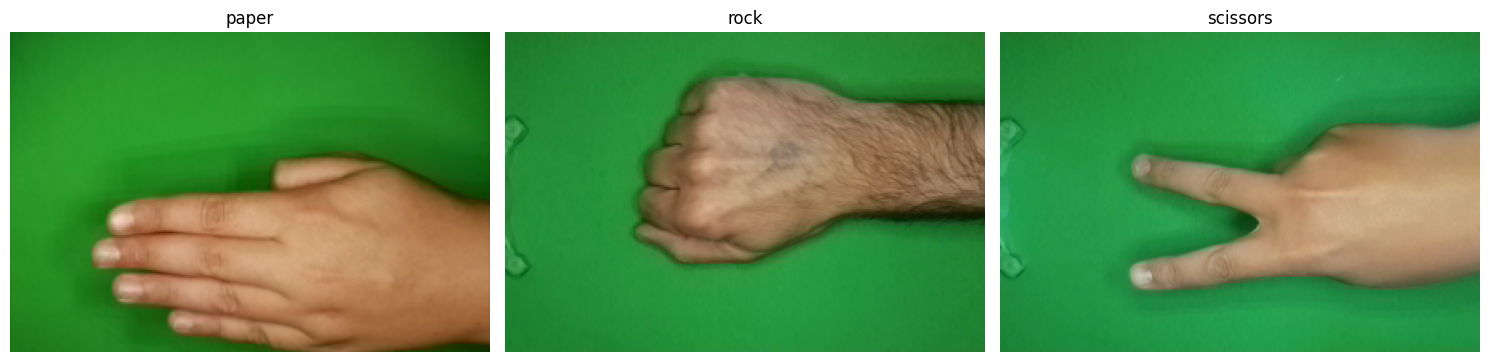

[INFO] Number of instances per class...


{'paper': 712, 'rock': 726, 'scissors': 750}

In [ ]:
# Check the downloaded folders
base_path = Path('/content')

# specify folders
folders = ['paper', 'rock', 'scissors']

# Dictionary to store the number of files in each folder
folder_file_counts = {}
first_images = []

# Using pathlib to count files (non-recursively) in each folder
for folder in folders:
    folder_path = base_path / folder
    # Check if the folder exists
    if folder_path.is_dir():
        # List non-recursive files
        files = [f for f in folder_path.iterdir() if f.is_file()]
        folder_file_counts[folder] = len(files)
        if files:
            first_images.append(files[0])
    else:
        folder_file_counts[folder] = 'Folder does not exist'

# Plotting the first image from each folder
fig, axes = plt.subplots(1, len(first_images), figsize=(15, 5))
for ax, img_path in zip(axes, first_images):
    img = Image.open(str(img_path))
    # print(img.size)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(img_path.parent.name)

plt.tight_layout()
plt.show()

print('[INFO] Number of instances per class...')
folder_file_counts

# Find cardinality of train, test and validation sets

In [ ]:
train_percentage = 0.7
test_percentage = 0.2
val_percentage = 0.1

samples_num_result = {}

for class_name, samples_num in folder_file_counts.items():
    temp_list = [x for x in range(samples_num)]
    train_samples, temp_test_samples = train_test_split(temp_list, test_size=test_percentage+val_percentage, random_state=RANDOM_STATE)
    test_samples, val_samples = train_test_split(temp_test_samples, test_size=0.33, random_state=RANDOM_STATE)
    samples_num_result[class_name] = [len(train_samples), len(test_samples), len(val_samples)]

for class_name, split in samples_num_result.items():
    print(f'[INFO] Sum of {class_name} is: {sum(split)}')
    print('='*30)

print('[INFO] splits per class are:')
samples_num_result

[INFO] Sum of paper is: 712
[INFO] Sum of rock is: 726
[INFO] Sum of scissors is: 750
[INFO] splits per class are:


{'paper': [498, 143, 71], 'rock': [508, 146, 72], 'scissors': [524, 151, 75]}

# Create a workspace structure such as this:
```text
├── train  
│   ├── class1  
|      ├── 1.jpg  
│      ├── 2.jpg  
│   ├── class2  
|      ├── 1.jpg  
│      ├── 2.jpg  
├── test  
│   ├── class1  
|      ├── 1.jpg  
│      ├── 2.jpg   
│   ├── class2  
|      ├── 1.jpg  
│      ├── 2.jpg
├── valid  
│   ├── class1  
|      ├── 1.jpg  
│      ├── 2.jpg   
│   ├── class2  
|      ├── 1.jpg  
│      ├── 2.jpg  
```

# Here in line 14 we use sorted() for reproducability purposes.
# Each time this code is called the result will be the same

In [ ]:
# Your dictionary with train and validation counts
original_path = Path('./')

# Create the new directory structure
for cls in samples_num_result.keys():
    (original_path / 'train' / cls).mkdir(parents=True, exist_ok=True)
    (original_path / 'test' / cls).mkdir(parents=True, exist_ok=True)
    (original_path / 'valid' / cls).mkdir(parents=True, exist_ok=True)

# Move the files according to the counts in the dictionary
for cls, (train_count, test_count, valid_count) in samples_num_result.items():
    # List all files in the original class directory
    # Sort to ensure reproducability
    files = sorted(list((original_path / cls).glob('*')))

    # Move the specified number of files to train and valid directories
    for i, file in enumerate(files):
        if i < train_count:
            shutil.move(str(file), str(original_path / 'train' / cls / file.name))
        elif i < train_count + test_count:
            shutil.move(str(file), str(original_path / 'test' / cls / file.name))
        elif i < train_count + test_count + valid_count:
            shutil.move(str(file), str(original_path / 'valid' / cls / file.name))


# Create Baseline models using conventional Machine Learning apporaches

In [ ]:
# create a function to compare results and return the reward
# random_agent_gesture and my_gesture are in [0, 1, 2]
def reward_func(random_agent_gesture: int,
                my_gesture: int) -> int:

    # Rules:
    # Paper (0) beats Rock (1)
    # Rock (1) beats Scissors (2)
    # Scissors (2) beats Paper (0)

    if random_agent_gesture == my_gesture:
        # It's a draw
        return 0
    elif (random_agent_gesture == 0 and my_gesture == 1) or \
         (random_agent_gesture == 1 and my_gesture == 2) or \
         (random_agent_gesture == 2 and my_gesture == 0):
        # my_gesture loses
        return -1
    else:
        # my_gesture wins
        return 1

def choose_action(predicted_label: int) -> int:
    if predicted_label == 0:    # if paper --> scissors
        return 2
    elif predicted_label == 1:  # if rock --> paper
        return 0
    else:
        return 1              # if scissors --> rock

# Load ViT transformer from here: https://huggingface.co/google/vit-base-patch16-224  

# Use ViT and on top of it a dense NN so as to set it trainable and use the combined model to classify the images

In [ ]:
class CustomViTClassifier(nn.Module):
    def __init__(self, num_classes, vit_model_name='google/vit-base-patch16-224'):
        super(CustomViTClassifier, self).__init__()
        # Load the pretrained ViT model
        self.vit = ViTForImageClassification.from_pretrained(vit_model_name)

        # Replace the classifier head of ViT with custom layers
        self.classifier = nn.Sequential(
            nn.Linear(self.vit.classifier.out_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        # Set self.training = False so as to use softmax only at inference mode
        self.training = False

        # Freeze all the parameters in the ViT model except for the classifier layer
        for name, param in self.named_parameters():
            if 'classifier' not in name:  # Freeze parameters not in the classifier layer
                param.requires_grad = False

        # Calculate and print the number of trainable and non-trainable parameters
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        non_trainable_params = total_params - trainable_params
        print(f"Total parameters: {total_params:_}")
        print(f"Trainable parameters: {trainable_params:_}")
        print(f"Non-trainable parameters: {non_trainable_params:_}")


    def forward(self, x):
        # Forward pass through ViT base
        x = self.vit(x).logits

        # Forward pass through the custom classifier
        x = self.classifier(x)

        if not self.training:
            x = torch.softmax(x, dim=1)

        return x

In [ ]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
class AddGaussianNoise:
    def __init__(self, mean=0., std_propotion=0.05):
        self.mean = mean
        self.std_propotion = std_propotion

    def __call__(self, tensor):
        # Check if x is a PIL Image and convert it to a Tensor
        if isinstance(tensor, Image.Image):
            transform = transforms.ToTensor()
            tensor = transform(tensor)

        max_val = 255 if torch.max(tensor) > 1 else 1
        return tensor + (torch.randn(tensor.size()) * (self.std_propotion * max_val) + self.mean)

# Loop of the game

# Define the image transformation for the game as it is prompted on step 4 in the assignment (Preprocess Image)

In [ ]:
# Define Random Agent's transformations
# Define the sequential transforms
p1 = 0.5
p2 = 0.5

game_loop_transform_vit = transforms.Compose([
    # random agent's transformations
    transforms.RandomVerticalFlip(p=p1),
    transforms.RandomHorizontalFlip(p=p2),
    AddGaussianNoise(mean=0, std_propotion=0.05)])

# Download fine-tuned model from my drive

In [ ]:
def download_custom_model(link, save_to='.'):
    # Sending a request to the URL
    response = requests.get(link)

    # create file path
    save_to = Path(save_to)
    filepath = save_to / "model.pt"

    # Checking if the request was successful
    if response.status_code == 200:
        # Writing the content to a .pt file
        with open(filepath, "wb") as file:
            file.write(response.content)
        print("Download complete. Model saved as model.pt")
    else:
        print("Failed to download the file. Status code:", response.status_code)

In [ ]:
# download_custom_model("https://drive.google.com/uc?export=download&confirm=no_antivirus&id=107gG6CxVL8OlIj5yGDv0qAcq3H8PNIQo")
download_custom_model("https://www.dropbox.com/scl/fi/ifwoxitny2nnxysxhlsj7/CustomViTClassifier_epoch_17_val_acc_1.0.pt?rlkey=zbryro10qm935jc3gcrrwnqvq&dl=1")

Download complete. Model saved as model.pt


# Load fine-tuned model stemmed from the fine-tuning process earlier

In [ ]:
# Instantiate the model with the number of classes you trained it on
def load_CustomViTClassifier(num_classes: int=3,
                             model_path: str=None):

    num_classes = num_classes  # replace with the actual number of classes you used
    model = CustomViTClassifier(num_classes)

    # Load the saved model weights
    model.load_state_dict(torch.load(f'{model_path}', map_location=torch.device('cpu'))['model_state_dict'])

    # Move the model to an appropriate device, e.g., GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # load processor
    processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

    return model, processor

In [ ]:
model, processor = load_CustomViTClassifier(3, '/content/model.pt')
model.eval()
model.to(device)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Total parameters: 87_081_707
Trainable parameters: 1_283_051
Non-trainable parameters: 85_798_656


CustomViTClassifier(
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
          

In [ ]:
def viTtransform_game_loop(image):
    # Firstly apply model's transforms
    image = processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
    # Secondly, apply the transforms that are specified in the assignment PDF
    image = game_loop_transform_vit(image)
    return image

# Re-Initialize datasets and concat them

In [ ]:
# Load the datasets
test_dataset = datasets.ImageFolder(original_path / 'test', transform=viTtransform_game_loop)

# Time to play the game

In [ ]:
# Remember class labels
CLASS_LABELS

{'paper': 0, 'rock': 1, 'scissors': 2}

In [ ]:
# set experiment parameters
N_samples = 1000
T_iterations = 100

In [ ]:
# Number of turns
score_results = []
for i in range(T_iterations):
    rewards = []
    print(f'[INFO] I am at iteration: {i+1}')
    for turn_num in tqdm(range(N_samples)):
        # Print game iteration
        # Randomly select an image and its label from the whole dataset
        idx = random.randint(0, len(test_dataset) - 1)
        image, true_label = test_dataset[idx]

        # Preprocess and prepare the image tensor for the model
        image = image.unsqueeze(0).to(device)  # Add batch dimension and send to device

        # Perform inference
        with torch.no_grad():
            output = model(image)
            predicted_label = int(torch.argmax(output, dim=1).item())  # Get the index of the max log-probability

        rewards.append(reward_func(true_label, choose_action(predicted_label)))

        # print(f"[INFO] Current cummulative reward is: {sum(rewards)}")

    # Append accuracy results
    score_results.append(sum(rewards))

    print(f"[INFO] [iter: {i+1}] Maximum cummulative reward is: {N_samples}")
    print(f"[INFO] [iter: {i+1}] Final cummulative reward is: {sum(rewards)}")

[INFO] I am at iteration: 1


100%|██████████| 1000/1000 [00:21<00:00, 46.48it/s]


[INFO] [iter: 1] Maximum cummulative reward is: 1000
[INFO] [iter: 1] Final cummulative reward is: 997
[INFO] I am at iteration: 2


100%|██████████| 1000/1000 [00:21<00:00, 46.75it/s]


[INFO] [iter: 2] Maximum cummulative reward is: 1000
[INFO] [iter: 2] Final cummulative reward is: 999
[INFO] I am at iteration: 3


100%|██████████| 1000/1000 [00:26<00:00, 38.14it/s]


[INFO] [iter: 3] Maximum cummulative reward is: 1000
[INFO] [iter: 3] Final cummulative reward is: 997
[INFO] I am at iteration: 4


100%|██████████| 1000/1000 [00:21<00:00, 46.38it/s]


[INFO] [iter: 4] Maximum cummulative reward is: 1000
[INFO] [iter: 4] Final cummulative reward is: 1000
[INFO] I am at iteration: 5


100%|██████████| 1000/1000 [00:21<00:00, 46.70it/s]


[INFO] [iter: 5] Maximum cummulative reward is: 1000
[INFO] [iter: 5] Final cummulative reward is: 997
[INFO] I am at iteration: 6


100%|██████████| 1000/1000 [00:21<00:00, 46.64it/s]


[INFO] [iter: 6] Maximum cummulative reward is: 1000
[INFO] [iter: 6] Final cummulative reward is: 1000
[INFO] I am at iteration: 7


100%|██████████| 1000/1000 [00:22<00:00, 44.20it/s]


[INFO] [iter: 7] Maximum cummulative reward is: 1000
[INFO] [iter: 7] Final cummulative reward is: 1000
[INFO] I am at iteration: 8


100%|██████████| 1000/1000 [00:21<00:00, 46.95it/s]


[INFO] [iter: 8] Maximum cummulative reward is: 1000
[INFO] [iter: 8] Final cummulative reward is: 999
[INFO] I am at iteration: 9


100%|██████████| 1000/1000 [00:21<00:00, 46.26it/s]


[INFO] [iter: 9] Maximum cummulative reward is: 1000
[INFO] [iter: 9] Final cummulative reward is: 996
[INFO] I am at iteration: 10


100%|██████████| 1000/1000 [00:21<00:00, 46.90it/s]


[INFO] [iter: 10] Maximum cummulative reward is: 1000
[INFO] [iter: 10] Final cummulative reward is: 997
[INFO] I am at iteration: 11


100%|██████████| 1000/1000 [00:21<00:00, 46.84it/s]


[INFO] [iter: 11] Maximum cummulative reward is: 1000
[INFO] [iter: 11] Final cummulative reward is: 997
[INFO] I am at iteration: 12


100%|██████████| 1000/1000 [00:21<00:00, 46.46it/s]


[INFO] [iter: 12] Maximum cummulative reward is: 1000
[INFO] [iter: 12] Final cummulative reward is: 999
[INFO] I am at iteration: 13


100%|██████████| 1000/1000 [00:21<00:00, 46.80it/s]


[INFO] [iter: 13] Maximum cummulative reward is: 1000
[INFO] [iter: 13] Final cummulative reward is: 997
[INFO] I am at iteration: 14


100%|██████████| 1000/1000 [00:21<00:00, 46.68it/s]


[INFO] [iter: 14] Maximum cummulative reward is: 1000
[INFO] [iter: 14] Final cummulative reward is: 999
[INFO] I am at iteration: 15


100%|██████████| 1000/1000 [00:21<00:00, 46.33it/s]


[INFO] [iter: 15] Maximum cummulative reward is: 1000
[INFO] [iter: 15] Final cummulative reward is: 1000
[INFO] I am at iteration: 16


100%|██████████| 1000/1000 [00:21<00:00, 46.57it/s]


[INFO] [iter: 16] Maximum cummulative reward is: 1000
[INFO] [iter: 16] Final cummulative reward is: 1000
[INFO] I am at iteration: 17


100%|██████████| 1000/1000 [00:21<00:00, 46.82it/s]


[INFO] [iter: 17] Maximum cummulative reward is: 1000
[INFO] [iter: 17] Final cummulative reward is: 1000
[INFO] I am at iteration: 18


100%|██████████| 1000/1000 [00:21<00:00, 46.25it/s]


[INFO] [iter: 18] Maximum cummulative reward is: 1000
[INFO] [iter: 18] Final cummulative reward is: 1000
[INFO] I am at iteration: 19


100%|██████████| 1000/1000 [00:21<00:00, 46.55it/s]


[INFO] [iter: 19] Maximum cummulative reward is: 1000
[INFO] [iter: 19] Final cummulative reward is: 1000
[INFO] I am at iteration: 20


100%|██████████| 1000/1000 [00:21<00:00, 46.72it/s]


[INFO] [iter: 20] Maximum cummulative reward is: 1000
[INFO] [iter: 20] Final cummulative reward is: 1000
[INFO] I am at iteration: 21


100%|██████████| 1000/1000 [00:21<00:00, 46.24it/s]


[INFO] [iter: 21] Maximum cummulative reward is: 1000
[INFO] [iter: 21] Final cummulative reward is: 999
[INFO] I am at iteration: 22


100%|██████████| 1000/1000 [00:21<00:00, 46.26it/s]


[INFO] [iter: 22] Maximum cummulative reward is: 1000
[INFO] [iter: 22] Final cummulative reward is: 1000
[INFO] I am at iteration: 23


100%|██████████| 1000/1000 [00:21<00:00, 47.26it/s]


[INFO] [iter: 23] Maximum cummulative reward is: 1000
[INFO] [iter: 23] Final cummulative reward is: 998
[INFO] I am at iteration: 24


100%|██████████| 1000/1000 [00:21<00:00, 46.17it/s]


[INFO] [iter: 24] Maximum cummulative reward is: 1000
[INFO] [iter: 24] Final cummulative reward is: 995
[INFO] I am at iteration: 25


100%|██████████| 1000/1000 [00:21<00:00, 46.17it/s]


[INFO] [iter: 25] Maximum cummulative reward is: 1000
[INFO] [iter: 25] Final cummulative reward is: 997
[INFO] I am at iteration: 26


100%|██████████| 1000/1000 [00:21<00:00, 47.43it/s]


[INFO] [iter: 26] Maximum cummulative reward is: 1000
[INFO] [iter: 26] Final cummulative reward is: 999
[INFO] I am at iteration: 27


100%|██████████| 1000/1000 [00:21<00:00, 46.37it/s]


[INFO] [iter: 27] Maximum cummulative reward is: 1000
[INFO] [iter: 27] Final cummulative reward is: 999
[INFO] I am at iteration: 28


100%|██████████| 1000/1000 [00:21<00:00, 45.84it/s]


[INFO] [iter: 28] Maximum cummulative reward is: 1000
[INFO] [iter: 28] Final cummulative reward is: 1000
[INFO] I am at iteration: 29


100%|██████████| 1000/1000 [00:21<00:00, 47.51it/s]


[INFO] [iter: 29] Maximum cummulative reward is: 1000
[INFO] [iter: 29] Final cummulative reward is: 996
[INFO] I am at iteration: 30


100%|██████████| 1000/1000 [00:21<00:00, 46.34it/s]


[INFO] [iter: 30] Maximum cummulative reward is: 1000
[INFO] [iter: 30] Final cummulative reward is: 997
[INFO] I am at iteration: 31


100%|██████████| 1000/1000 [00:21<00:00, 46.23it/s]


[INFO] [iter: 31] Maximum cummulative reward is: 1000
[INFO] [iter: 31] Final cummulative reward is: 996
[INFO] I am at iteration: 32


100%|██████████| 1000/1000 [00:21<00:00, 47.45it/s]


[INFO] [iter: 32] Maximum cummulative reward is: 1000
[INFO] [iter: 32] Final cummulative reward is: 1000
[INFO] I am at iteration: 33


100%|██████████| 1000/1000 [00:21<00:00, 46.25it/s]


[INFO] [iter: 33] Maximum cummulative reward is: 1000
[INFO] [iter: 33] Final cummulative reward is: 997
[INFO] I am at iteration: 34


100%|██████████| 1000/1000 [00:21<00:00, 46.11it/s]


[INFO] [iter: 34] Maximum cummulative reward is: 1000
[INFO] [iter: 34] Final cummulative reward is: 996
[INFO] I am at iteration: 35


100%|██████████| 1000/1000 [00:21<00:00, 47.31it/s]


[INFO] [iter: 35] Maximum cummulative reward is: 1000
[INFO] [iter: 35] Final cummulative reward is: 1000
[INFO] I am at iteration: 36


100%|██████████| 1000/1000 [00:21<00:00, 45.87it/s]


[INFO] [iter: 36] Maximum cummulative reward is: 1000
[INFO] [iter: 36] Final cummulative reward is: 997
[INFO] I am at iteration: 37


100%|██████████| 1000/1000 [00:21<00:00, 45.84it/s]


[INFO] [iter: 37] Maximum cummulative reward is: 1000
[INFO] [iter: 37] Final cummulative reward is: 1000
[INFO] I am at iteration: 38


100%|██████████| 1000/1000 [00:21<00:00, 47.57it/s]


[INFO] [iter: 38] Maximum cummulative reward is: 1000
[INFO] [iter: 38] Final cummulative reward is: 999
[INFO] I am at iteration: 39


100%|██████████| 1000/1000 [00:21<00:00, 46.02it/s]


[INFO] [iter: 39] Maximum cummulative reward is: 1000
[INFO] [iter: 39] Final cummulative reward is: 998
[INFO] I am at iteration: 40


100%|██████████| 1000/1000 [00:21<00:00, 46.32it/s]


[INFO] [iter: 40] Maximum cummulative reward is: 1000
[INFO] [iter: 40] Final cummulative reward is: 1000
[INFO] I am at iteration: 41


100%|██████████| 1000/1000 [00:21<00:00, 47.52it/s]


[INFO] [iter: 41] Maximum cummulative reward is: 1000
[INFO] [iter: 41] Final cummulative reward is: 1000
[INFO] I am at iteration: 42


100%|██████████| 1000/1000 [00:21<00:00, 45.97it/s]


[INFO] [iter: 42] Maximum cummulative reward is: 1000
[INFO] [iter: 42] Final cummulative reward is: 1000
[INFO] I am at iteration: 43


100%|██████████| 1000/1000 [00:21<00:00, 46.39it/s]


[INFO] [iter: 43] Maximum cummulative reward is: 1000
[INFO] [iter: 43] Final cummulative reward is: 997
[INFO] I am at iteration: 44


100%|██████████| 1000/1000 [00:21<00:00, 47.41it/s]


[INFO] [iter: 44] Maximum cummulative reward is: 1000
[INFO] [iter: 44] Final cummulative reward is: 998
[INFO] I am at iteration: 45


100%|██████████| 1000/1000 [00:21<00:00, 45.49it/s]


[INFO] [iter: 45] Maximum cummulative reward is: 1000
[INFO] [iter: 45] Final cummulative reward is: 999
[INFO] I am at iteration: 46


100%|██████████| 1000/1000 [00:21<00:00, 46.14it/s]


[INFO] [iter: 46] Maximum cummulative reward is: 1000
[INFO] [iter: 46] Final cummulative reward is: 997
[INFO] I am at iteration: 47


100%|██████████| 1000/1000 [00:21<00:00, 47.41it/s]


[INFO] [iter: 47] Maximum cummulative reward is: 1000
[INFO] [iter: 47] Final cummulative reward is: 997
[INFO] I am at iteration: 48


100%|██████████| 1000/1000 [00:21<00:00, 46.18it/s]


[INFO] [iter: 48] Maximum cummulative reward is: 1000
[INFO] [iter: 48] Final cummulative reward is: 1000
[INFO] I am at iteration: 49


100%|██████████| 1000/1000 [00:21<00:00, 46.29it/s]


[INFO] [iter: 49] Maximum cummulative reward is: 1000
[INFO] [iter: 49] Final cummulative reward is: 999
[INFO] I am at iteration: 50


100%|██████████| 1000/1000 [00:21<00:00, 47.41it/s]


[INFO] [iter: 50] Maximum cummulative reward is: 1000
[INFO] [iter: 50] Final cummulative reward is: 998
[INFO] I am at iteration: 51


100%|██████████| 1000/1000 [00:21<00:00, 46.12it/s]


[INFO] [iter: 51] Maximum cummulative reward is: 1000
[INFO] [iter: 51] Final cummulative reward is: 998
[INFO] I am at iteration: 52


100%|██████████| 1000/1000 [00:21<00:00, 46.03it/s]


[INFO] [iter: 52] Maximum cummulative reward is: 1000
[INFO] [iter: 52] Final cummulative reward is: 1000
[INFO] I am at iteration: 53


100%|██████████| 1000/1000 [00:21<00:00, 47.41it/s]


[INFO] [iter: 53] Maximum cummulative reward is: 1000
[INFO] [iter: 53] Final cummulative reward is: 999
[INFO] I am at iteration: 54


100%|██████████| 1000/1000 [00:21<00:00, 46.38it/s]


[INFO] [iter: 54] Maximum cummulative reward is: 1000
[INFO] [iter: 54] Final cummulative reward is: 1000
[INFO] I am at iteration: 55


100%|██████████| 1000/1000 [00:21<00:00, 46.11it/s]


[INFO] [iter: 55] Maximum cummulative reward is: 1000
[INFO] [iter: 55] Final cummulative reward is: 999
[INFO] I am at iteration: 56


100%|██████████| 1000/1000 [00:21<00:00, 47.28it/s]


[INFO] [iter: 56] Maximum cummulative reward is: 1000
[INFO] [iter: 56] Final cummulative reward is: 999
[INFO] I am at iteration: 57


100%|██████████| 1000/1000 [00:21<00:00, 45.95it/s]


[INFO] [iter: 57] Maximum cummulative reward is: 1000
[INFO] [iter: 57] Final cummulative reward is: 1000
[INFO] I am at iteration: 58


100%|██████████| 1000/1000 [00:21<00:00, 46.08it/s]


[INFO] [iter: 58] Maximum cummulative reward is: 1000
[INFO] [iter: 58] Final cummulative reward is: 998
[INFO] I am at iteration: 59


100%|██████████| 1000/1000 [00:21<00:00, 47.28it/s]


[INFO] [iter: 59] Maximum cummulative reward is: 1000
[INFO] [iter: 59] Final cummulative reward is: 998
[INFO] I am at iteration: 60


100%|██████████| 1000/1000 [00:21<00:00, 46.33it/s]


[INFO] [iter: 60] Maximum cummulative reward is: 1000
[INFO] [iter: 60] Final cummulative reward is: 1000
[INFO] I am at iteration: 61


100%|██████████| 1000/1000 [00:21<00:00, 46.04it/s]


[INFO] [iter: 61] Maximum cummulative reward is: 1000
[INFO] [iter: 61] Final cummulative reward is: 1000
[INFO] I am at iteration: 62


100%|██████████| 1000/1000 [00:21<00:00, 47.14it/s]


[INFO] [iter: 62] Maximum cummulative reward is: 1000
[INFO] [iter: 62] Final cummulative reward is: 999
[INFO] I am at iteration: 63


100%|██████████| 1000/1000 [00:21<00:00, 46.68it/s]


[INFO] [iter: 63] Maximum cummulative reward is: 1000
[INFO] [iter: 63] Final cummulative reward is: 1000
[INFO] I am at iteration: 64


100%|██████████| 1000/1000 [00:21<00:00, 46.31it/s]


[INFO] [iter: 64] Maximum cummulative reward is: 1000
[INFO] [iter: 64] Final cummulative reward is: 1000
[INFO] I am at iteration: 65


100%|██████████| 1000/1000 [00:21<00:00, 46.76it/s]


[INFO] [iter: 65] Maximum cummulative reward is: 1000
[INFO] [iter: 65] Final cummulative reward is: 997
[INFO] I am at iteration: 66


100%|██████████| 1000/1000 [00:21<00:00, 46.75it/s]


[INFO] [iter: 66] Maximum cummulative reward is: 1000
[INFO] [iter: 66] Final cummulative reward is: 1000
[INFO] I am at iteration: 67


100%|██████████| 1000/1000 [00:21<00:00, 45.98it/s]


[INFO] [iter: 67] Maximum cummulative reward is: 1000
[INFO] [iter: 67] Final cummulative reward is: 999
[INFO] I am at iteration: 68


100%|██████████| 1000/1000 [00:21<00:00, 46.73it/s]


[INFO] [iter: 68] Maximum cummulative reward is: 1000
[INFO] [iter: 68] Final cummulative reward is: 1000
[INFO] I am at iteration: 69


100%|██████████| 1000/1000 [00:21<00:00, 46.84it/s]


[INFO] [iter: 69] Maximum cummulative reward is: 1000
[INFO] [iter: 69] Final cummulative reward is: 999
[INFO] I am at iteration: 70


100%|██████████| 1000/1000 [00:21<00:00, 46.01it/s]


[INFO] [iter: 70] Maximum cummulative reward is: 1000
[INFO] [iter: 70] Final cummulative reward is: 1000
[INFO] I am at iteration: 71


100%|██████████| 1000/1000 [00:21<00:00, 46.04it/s]


[INFO] [iter: 71] Maximum cummulative reward is: 1000
[INFO] [iter: 71] Final cummulative reward is: 999
[INFO] I am at iteration: 72


100%|██████████| 1000/1000 [00:21<00:00, 46.98it/s]


[INFO] [iter: 72] Maximum cummulative reward is: 1000
[INFO] [iter: 72] Final cummulative reward is: 999
[INFO] I am at iteration: 73


100%|██████████| 1000/1000 [00:21<00:00, 46.11it/s]


[INFO] [iter: 73] Maximum cummulative reward is: 1000
[INFO] [iter: 73] Final cummulative reward is: 998
[INFO] I am at iteration: 74


100%|██████████| 1000/1000 [00:21<00:00, 46.38it/s]


[INFO] [iter: 74] Maximum cummulative reward is: 1000
[INFO] [iter: 74] Final cummulative reward is: 1000
[INFO] I am at iteration: 75


100%|██████████| 1000/1000 [00:21<00:00, 47.11it/s]


[INFO] [iter: 75] Maximum cummulative reward is: 1000
[INFO] [iter: 75] Final cummulative reward is: 1000
[INFO] I am at iteration: 76


100%|██████████| 1000/1000 [00:21<00:00, 46.20it/s]


[INFO] [iter: 76] Maximum cummulative reward is: 1000
[INFO] [iter: 76] Final cummulative reward is: 1000
[INFO] I am at iteration: 77


100%|██████████| 1000/1000 [00:21<00:00, 46.19it/s]


[INFO] [iter: 77] Maximum cummulative reward is: 1000
[INFO] [iter: 77] Final cummulative reward is: 998
[INFO] I am at iteration: 78


100%|██████████| 1000/1000 [00:21<00:00, 47.12it/s]


[INFO] [iter: 78] Maximum cummulative reward is: 1000
[INFO] [iter: 78] Final cummulative reward is: 998
[INFO] I am at iteration: 79


100%|██████████| 1000/1000 [00:21<00:00, 46.03it/s]


[INFO] [iter: 79] Maximum cummulative reward is: 1000
[INFO] [iter: 79] Final cummulative reward is: 996
[INFO] I am at iteration: 80


100%|██████████| 1000/1000 [00:21<00:00, 46.21it/s]


[INFO] [iter: 80] Maximum cummulative reward is: 1000
[INFO] [iter: 80] Final cummulative reward is: 1000
[INFO] I am at iteration: 81


100%|██████████| 1000/1000 [00:21<00:00, 47.49it/s]


[INFO] [iter: 81] Maximum cummulative reward is: 1000
[INFO] [iter: 81] Final cummulative reward is: 1000
[INFO] I am at iteration: 82


100%|██████████| 1000/1000 [00:21<00:00, 46.28it/s]


[INFO] [iter: 82] Maximum cummulative reward is: 1000
[INFO] [iter: 82] Final cummulative reward is: 998
[INFO] I am at iteration: 83


100%|██████████| 1000/1000 [00:21<00:00, 46.23it/s]


[INFO] [iter: 83] Maximum cummulative reward is: 1000
[INFO] [iter: 83] Final cummulative reward is: 1000
[INFO] I am at iteration: 84


100%|██████████| 1000/1000 [00:21<00:00, 47.33it/s]


[INFO] [iter: 84] Maximum cummulative reward is: 1000
[INFO] [iter: 84] Final cummulative reward is: 999
[INFO] I am at iteration: 85


100%|██████████| 1000/1000 [00:21<00:00, 45.87it/s]


[INFO] [iter: 85] Maximum cummulative reward is: 1000
[INFO] [iter: 85] Final cummulative reward is: 999
[INFO] I am at iteration: 86


100%|██████████| 1000/1000 [00:21<00:00, 45.74it/s]


[INFO] [iter: 86] Maximum cummulative reward is: 1000
[INFO] [iter: 86] Final cummulative reward is: 1000
[INFO] I am at iteration: 87


100%|██████████| 1000/1000 [00:21<00:00, 47.56it/s]


[INFO] [iter: 87] Maximum cummulative reward is: 1000
[INFO] [iter: 87] Final cummulative reward is: 999
[INFO] I am at iteration: 88


100%|██████████| 1000/1000 [00:21<00:00, 46.14it/s]


[INFO] [iter: 88] Maximum cummulative reward is: 1000
[INFO] [iter: 88] Final cummulative reward is: 999
[INFO] I am at iteration: 89


100%|██████████| 1000/1000 [00:21<00:00, 46.13it/s]


[INFO] [iter: 89] Maximum cummulative reward is: 1000
[INFO] [iter: 89] Final cummulative reward is: 998
[INFO] I am at iteration: 90


100%|██████████| 1000/1000 [00:21<00:00, 47.47it/s]


[INFO] [iter: 90] Maximum cummulative reward is: 1000
[INFO] [iter: 90] Final cummulative reward is: 996
[INFO] I am at iteration: 91


100%|██████████| 1000/1000 [00:21<00:00, 45.90it/s]


[INFO] [iter: 91] Maximum cummulative reward is: 1000
[INFO] [iter: 91] Final cummulative reward is: 999
[INFO] I am at iteration: 92


100%|██████████| 1000/1000 [00:21<00:00, 45.89it/s]


[INFO] [iter: 92] Maximum cummulative reward is: 1000
[INFO] [iter: 92] Final cummulative reward is: 999
[INFO] I am at iteration: 93


100%|██████████| 1000/1000 [00:21<00:00, 47.45it/s]


[INFO] [iter: 93] Maximum cummulative reward is: 1000
[INFO] [iter: 93] Final cummulative reward is: 1000
[INFO] I am at iteration: 94


100%|██████████| 1000/1000 [00:21<00:00, 45.98it/s]


[INFO] [iter: 94] Maximum cummulative reward is: 1000
[INFO] [iter: 94] Final cummulative reward is: 998
[INFO] I am at iteration: 95


100%|██████████| 1000/1000 [00:21<00:00, 45.87it/s]


[INFO] [iter: 95] Maximum cummulative reward is: 1000
[INFO] [iter: 95] Final cummulative reward is: 1000
[INFO] I am at iteration: 96


100%|██████████| 1000/1000 [00:21<00:00, 47.42it/s]


[INFO] [iter: 96] Maximum cummulative reward is: 1000
[INFO] [iter: 96] Final cummulative reward is: 997
[INFO] I am at iteration: 97


100%|██████████| 1000/1000 [00:21<00:00, 45.84it/s]


[INFO] [iter: 97] Maximum cummulative reward is: 1000
[INFO] [iter: 97] Final cummulative reward is: 1000
[INFO] I am at iteration: 98


100%|██████████| 1000/1000 [00:21<00:00, 45.89it/s]


[INFO] [iter: 98] Maximum cummulative reward is: 1000
[INFO] [iter: 98] Final cummulative reward is: 1000
[INFO] I am at iteration: 99


100%|██████████| 1000/1000 [00:21<00:00, 46.99it/s]


[INFO] [iter: 99] Maximum cummulative reward is: 1000
[INFO] [iter: 99] Final cummulative reward is: 1000
[INFO] I am at iteration: 100


100%|██████████| 1000/1000 [00:21<00:00, 45.95it/s]

[INFO] [iter: 100] Maximum cummulative reward is: 1000
[INFO] [iter: 100] Final cummulative reward is: 1000


# Print final average score for 100 experiments of 1000 rsp rounds

In [ ]:
print(f'[INFO] Average Reward is: {sum(score_results) / len(score_results)}/{N_samples}')

[INFO] Average Reward is: 998.76/1000


# Test the our model to real images from the web

In [ ]:
inverted_CLASS_LABELS = {value: key for key, value in CLASS_LABELS.items()}
inverted_CLASS_LABELS

{0: 'paper', 1: 'rock', 2: 'scissors'}

# Paper

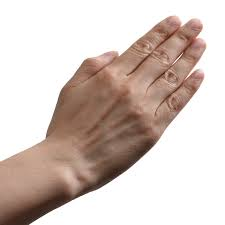

In [ ]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTwT8Zq8hkHN85-ym7_SCW0LFAOelBbSmNbhQ&usqp=CAU'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
image

In [ ]:
image = processor(images=image, return_tensors="pt")['pixel_values'].to(device)

output = model(image)
predicted_label = int(torch.argmax(output, dim=1).item())  # Get the index of the max log-probability
print(f'[INFO] The predicted label is: {inverted_CLASS_LABELS[predicted_label]}')

[INFO] The predicted label is: paper


# Rock

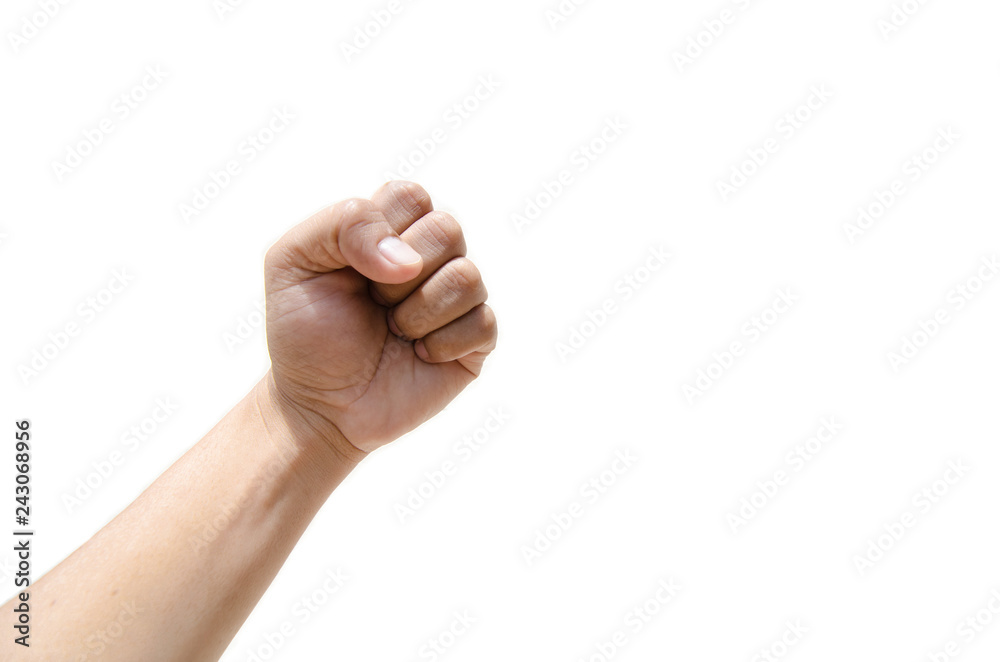

In [ ]:
url = 'https://as2.ftcdn.net/v2/jpg/02/43/06/89/1000_F_243068956_Gk65xafr8n50DcuEFvdf0GPCrbN28ICE.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
image

In [ ]:
image = processor(images=image, return_tensors="pt")['pixel_values'].to(device)

output = model(image)
predicted_label = int(torch.argmax(output, dim=1).item())  # Get the index of the max log-probability
print(f'[INFO] The predicted label is: {inverted_CLASS_LABELS[predicted_label]}')

[INFO] The predicted label is: rock


# Scissors

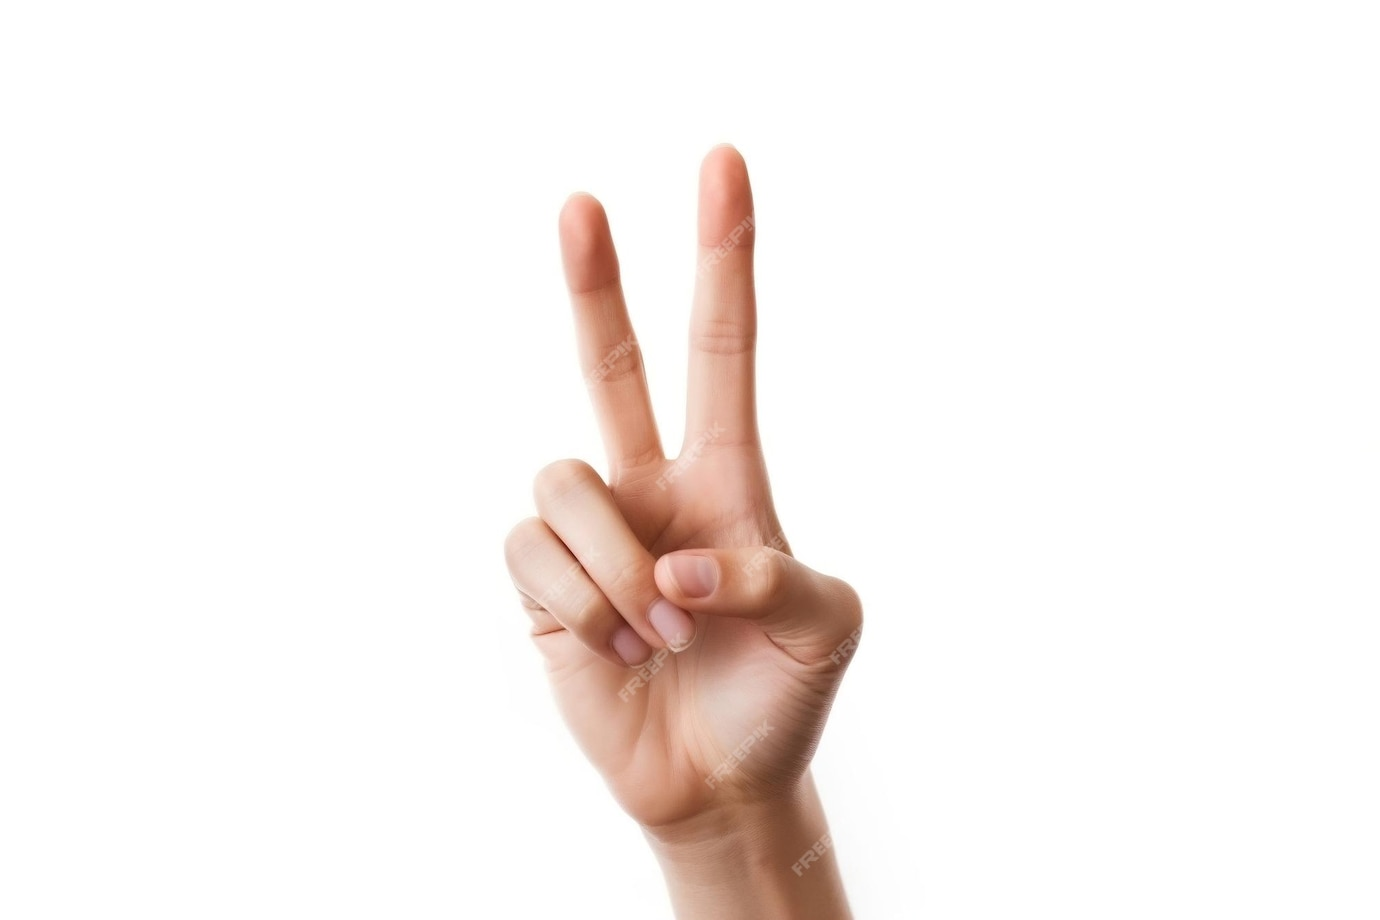

In [ ]:
url = 'https://img.freepik.com/premium-photo/peace-sign-hand-gesture-isolated-white-background-ai_894067-5289.jpg?w=1380'
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
image

In [ ]:
image = processor(images=image, return_tensors="pt")['pixel_values'].to(device)

output = model(image)
predicted_label = int(torch.argmax(output, dim=1).item())  # Get the index of the max log-probability
print(f'[INFO] The predicted label is: {inverted_CLASS_LABELS[predicted_label]}')

[INFO] The predicted label is: scissors
